## EECS 531 Assignment 1

Due Saturday Feb 15 before midnight. 120 points total.

### Submitting assignments to Canvas

- You can use this notebook as a starting point for completing the assignment.
- For jupyter notebooks, submit the .ipynb file and a pdf export of the notebook.
- Make sure you check that the pdf export represents the latest state of your notebook and that the equations and figures are properly rendered.

- If you decide not to a notebook, writeup your assignment using latex and submit a pdf with your code.  The writeup should include relevant code with description if it can fit on a page.  

- Use the following format for filenames:
  - `EECS531-A1-yourcaseid.ipynb`
  - `EECS531-A1-yourcaseid.pdf`

- If you have more than these two files, put any additional files in a directory named `EECS531-A1-yourcaseid`. Do not include binaries or large data files. Then zip this directory and submit it with the name `EECS531-A1-yourcaseid.zip`.  Do not use other compression formats.  The `.ipynb` file can be included in the zipped directory, but make sure you submit the `.pdf` file along with the `.zip` file.  This is so it appears at the top level on canvas, which allows for easier grading.

Some of exercises below aren't specified in great detail and you may need to spend sometime making sense of the questions themselves, which you can do from the readings and other sources.  You also might need to fill in some blanks or make some assumptions.  The spirit behind this approach is explained in [The Problem with Problems](http://web.mit.edu/6.969/www/readings/mazur.pdf) by Eric Mazur, which I encourage everyone to read.

Many of these exercises also involve a wide range of choice in terms of how you complete them.  Since each exercise is only worth 5 pts, in terms of grading I'm mainly looking for whether you demonstrate understanding of the concepts. Concise answers are sufficient if you demonstrate clear understanding.  If you find yourself writing very lengthy answers and going deeper and deeper into a question, consider moving that work to the exploration component.

## Anna Sedlackova axs1202

### Exercise 1. Convolution (15 pts)

1.1 (5 pts) Using the discrete definition, show that convolution is a linear operation, i.e.

$$
(f + g) * c = f*c + g*c \quad \textrm{and} \quad (\lambda f)*c = \lambda(f*c)
$$

1.2. (5 pts) Show that the convolution of a separable two-dimensional filter kernel $\mathbf{K} = \mathbf{u}\mathbf{v^T}$ is equivalent to a 1-D horizontal convolution with kernel $\mathbf{h}$ followed by a 1-D vertical convolution with kernel $\mathbf{v}$.

1.3. (5 pts) Describe the advantages and limitations of such an approach.

## Exercise 1
### 1.1

Proof for:
$$
((f + g) * c) (n) = \sum_{m=-\infty}^\infty (f + g)(n) * c(m - n) \\
((f + g) * c) (n) = \sum_{m=-\infty}^\infty [f(n) + g(n)] * c(m - n) \\
((f + g) * c) (n) = \sum_{m=-\infty}^\infty f(n) * c(m - n) + \sum_{m=-\infty}^\infty g(n) * c(m - n)\\
((f + g) * c) (n) = (f * c)(n) + (g * c)n\\
$$

Proof for:
$$
(\lambda f)*c(n) = \sum_{m=-\infty}^\infty (\lambda f)(n) * c(m - n) \\
(\lambda f)*c(n) = \sum_{m=-\infty}^\infty \lambda * f(n) * c(m - n) \\
(\lambda f)*c(n) = \lambda * (f * c)(n) \\
$$

### 1.2

We know the following about K:
$$
K = u * v^{T} \epsilon R^{n * m}
$$

Let 
$$
X \epsilon R^{n * m}
$$

Based on the definition of convolution, we can write the following:

$$
(K * X)(i, j) = \sum_{k=1}^n \sum_{l=1}^m K(k, l) X(i - k, j - l) \\
(K * X)(i, j) = \sum_{k=1}^n \sum_{l=1}^m [u(k) v(l)] X(i - k, j - l) \\
(K * X)(i, j) = \sum_{k=1}^n u(k) [\sum_{l=1}^m v(l) X(i - k, j - l)] \\
(K * X)(i, j) = \sum_{k=1}^n u(k) [(v * X)(i - k, j)] \\
(K * X)(i, j) = [u * (v * X)](i, j)
$$

Where the u part corresponds to vertical convolution and (v * X) to horizontal convolution.

### 1.3

#### Advantage of applying two 1D kernels, v and u VS kernel K
When applying kernel K that involves doing a double sum, it is very possible that all entries of K * X will not be able to fit into the processor's cache. However, if one dimension is very large compared to another, it may be possible to first apply a 1D filter over the smaller dimension (whether that is the row or column dimension) and then apply the second 1D filter over the summary of the results. Hopefully these two separate operations will be able to fit into the processor's cache.


### Exercise 2.  Linear Filtering (20 pts)

Here you will write functions to implement 2D filtering.  Refer to Szeliski chapter 3 and more specifically section 3.2.  For this exercise, you should implement the filter functions "by hand", i.e. do not use a library.  Your answers should be explanatory.

2.1 (5 pts) Write a function that implements linear filtering (i.e. equation 3.12 or 3.14 in Szeliski).  Write a short "doc string" that explains your function and its arguments.  Also explain how you handled boundaries.

2.2 (5 pts) Demonstrate the correctness of your implementation.

2.3 (5 pts) Define blurring filters of different sizes and apply them to images.  Explain how the kernel structure achives the blurring operation, and illustrate it by showing original and filtered images side by side.

2.4 (5 pts) Define a different filter kernel (besides blurring).  Demonstrate it by apply it to images and explain how its structure achieves the intended function.  

## Exercise 2
### 2.1

We can filter images in order to add soft blur, sharpen details, accentuate edges, or remove noise. We are going to perform neighborhood  filtering, or convolution. The function  takes in an image matrix, and a kernel array that we will convolve the image array with.


In [181]:
# all import statements
#!pip install opencv-python

import cv2 as cv
import numpy as np
from PIL import Image
import cv2

import skimage
from skimage.util import random_noise

# matplotlib for plotting images
import matplotlib.pyplot as plt

# specific packages from skimage
from skimage.color import rgb2gray
from skimage.data import camera
from skimage import feature
from skimage.io import imread
from skimage.filters import roberts, sobel, scharr, prewitt

In order to handle boundaries, I compute the offset of the kernel, which is half of its width/length - 1. When parsing the image, I ignore the offset in the image array so the resulting convolved image is smaller than the original by the size of the offset.

In [182]:
def apply_2D_filter(kernel, image_array):
    """
    Applies a linear filter to an array.
    
    Parameters:
    kernel (list of lists): 2D kernel that modifies the image
    image_array (list of lists): input image as an 2D grayscale 

    Returns:
    int: modified image array, convolved with the kernel
    """
    
    image_array = np.asarray(image_array)
    kernel = np.asarray(kernel)

    #make a new image array
    offset = len(kernel) // 2
    
    new_image_array = np.zeros(shape = (image_array.shape[0] - 2 * offset, image_array.shape[1] - 2 * offset))
    
    for i in range(offset, image_array.shape[0] - offset):
            for j in range(offset, image_array.shape[1] - offset):

                #Place the kernel anchor on top of a determined pixel, with the rest of the kernel overlaying the corresponding local pixels in the image
                patch = image_array[i - offset : i - offset + kernel.shape[0], j - offset : j - offset + kernel.shape[0]]
                
                #Multiply the kernel coefficients by the corresponding image pixel values and sum the result.
                product = np.multiply(patch, kernel)
                sum = np.sum(product)
                
                #Place the result to the location of the anchor in the input image.
                new_image_array[i - offset][j - offset] = sum
                
    new_image_array = new_image_array.astype(int)
    return new_image_array

### 2.2

We will demonstrate the correctness by running multiple base and edge cases with the method and printing them.


In [183]:
image = [[45, 60, 98, 127, 132, 133, 137, 133],
     [46, 65, 98, 123, 126, 128, 131, 133],
     [47, 65, 96, 115, 119, 123, 135, 137],
     [47, 63, 91, 107, 113, 122, 138, 134],
     [50, 59, 80, 97, 110, 123, 133, 134],
     [49, 53, 68, 83, 97, 113, 128, 133],
     [50, 50, 58, 70, 84, 102, 116, 126],
     [50, 50, 52, 58, 69, 86, 101, 120]]
kernel = [[0.1, 0.1, 0.1],
    [0.1, 0.2, 0.1],
    [0.1, 0.1, 0.1]]

result1 = apply_2D_filter(kernel, image)
print(result1)
print()

# lets try this with a larger kernel
kernel2 = [[0.1, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.2, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.1]]

result2 = apply_2D_filter(kernel2, image)
print(result2)

# lets make the input image a rectangle rather than a square
image2 = [[45, 60, 98, 127, 132, 133],
     [46, 65, 98, 123, 126, 128],
     [47, 65, 96, 115, 119, 123],
     [47, 63, 91, 107, 113, 122],
     [50, 59, 80, 97, 110, 123],
     [49, 53, 68, 83, 97, 113],
     [50, 50, 58, 70, 84, 102],
     [50, 50, 52, 58, 69, 86]]

print()
result3 = apply_2D_filter(kernel, image2)
print(result3)

[[ 68  94 115 125 129 132]
 [ 68  91 110 119 125 131]
 [ 66  86 103 114 123 131]
 [ 61  78  94 107 120 129]
 [ 57  68  83  97 111 123]
 [ 53  60  70  84  99 114]]

[[227 268 305 326]
 [215 254 291 315]
 [200 235 273 301]
 [182 214 249 281]]

[[ 68  94 115 125]
 [ 68  91 110 119]
 [ 66  86 103 114]
 [ 61  78  94 107]
 [ 57  68  83  97]
 [ 53  60  70  84]]


### 2.3

We will modify our code from above to include the PIL package for loading images. 


In [184]:
def apply_2d_filter_image(kernel, image_path, title):
    """
    Applies a linear filter to an image.
    
    Parameters:
    kernel (list of lists): 2D kernel that modifies the image
    image_array (list of lists): input image as an 2D grayscale 
    title (string): label on the figure
    """
    
    # Load an image based on the given path
    image = Image.open(image_path).convert('L')
    
    image_array = np.array(image)
    
    # Convert the images and plot them
    new_image = apply_2D_filter(kernel, image_array).astype('uint8')
    
    # display results
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(8, 4))

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(new_image, cmap=plt.cm.gray)
    ax[1].set_title(title)

    plt.tight_layout()
    plt.show()

Now let's test it with the two images below using the box blur filter:

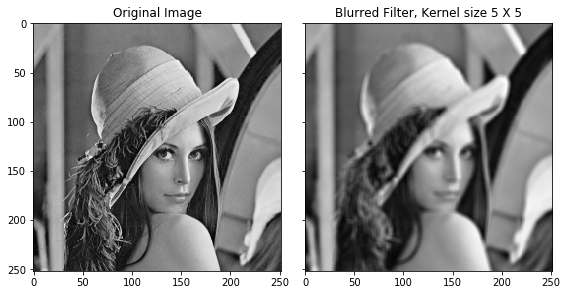

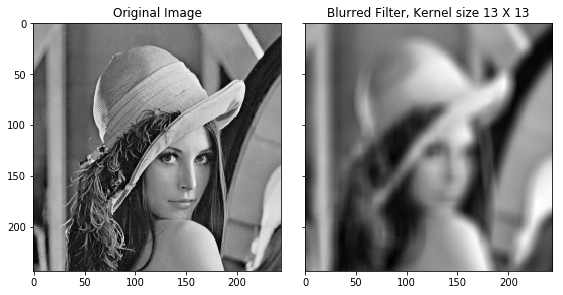

In [185]:
# let's start with a smaller kernel and build the larger ones to see the increase in blur
kernel1 = 1/(5*5)*np.ones((5,5)) 
kernel2 = 1/(9*9)*np.ones((9,9)) 
kernel3 = 1/(13*13)*np.ones((13,13)) 
kernel4 = 1/(21*21)*np.ones((21,21))


apply_2d_filter_image(kernel1, 'images/lady.png', 'Blurred Filter, Kernel size 5 X 5')
apply_2d_filter_image(kernel2, 'images/lady.png', 'Blurred Filter, Kernel size 9 X 9')
apply_2d_filter_image(kernel3, 'images/lady.png', 'Blurred Filter, Kernel size 13 X 13')
apply_2d_filter_image(kernel4, 'images/lady.png', 'Blurred Filter, Kernel size 21 X 21')


We are replacing the pixel value in the original image at the anchor point of the kernel with the sum of its neighbor values multiplied by the kernel weights. The larger the size of the kernel the bigger the blur, this is because we are sourcing more information from more pixels even further away.

### 2.4
Now let's try different filters to achieve a sharpening effect. We are going to use a high-pass filter. The sharpening kernel functions by boosting the anchor pixel when the neigborhood pixels differ.

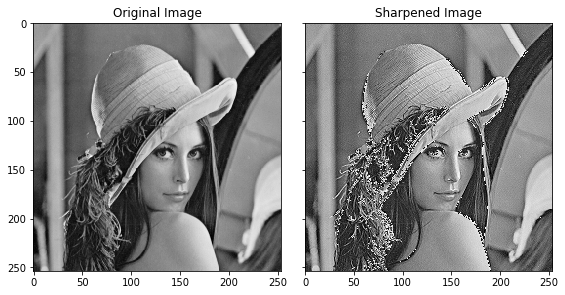

In [186]:
# sharpening high-pass filter
kernel = [[0, -0.5, 0],
        [-0.5, 3, -0.5],
        [0, -0.5, 0]]


apply_2d_filter_image(kernel, 'images/lady.png', 'Sharpened Image')

### Exercise 3.  Non-linear Filtering (15 pts)

In this exercise you should also implement the filter by hand.  You should be able to modify your code from the previous exercise.

3.1 (5 pts) Define a function that implements some type of *non-linear* filtering.  

3.2 (5 pts) Show why this cannot be implemented by a linear filter.

3.3 (5 pts) Demonstrate this filter by applying it to images that are appropriate for illustrating its function.

## Exercise 3
### 3.1

We are going to use a 2D median non-linear filter by reusing the code from above and slightly modifying it. In this implementation, we are going to be ignoring boundaries and slightly shrinking the processed image as in the implementation from problem 2.


In [187]:
def apply_2D_non_linear_filter(width_w, height_w, image_array): 
    """
    Applies a non-linear filter to an image array.
    
    Parameters:
    width_w (int): width of the window we will be iterating over to get the median value
    width_h (int): height of the window we will be iterating over to get the median value 
    
    Returns:
    int: modified image array
    """
    
    image_array = np.asarray(image_array)

    # get the offset for the new image array
    offset_w = width_w//2
    offset_h = height_w//2
    
    #make a new image array
    new_image_array = np.zeros(shape = (image_array.shape[0] - 2 * offset_w , image_array.shape[1] - 2 * offset_h))
    window = np.empty(shape = (width_w * height_w))

    for i in range(offset_w, image_array.shape[0] - offset_w):
        for j in range(offset_h, image_array.shape[1] - offset_h):
            k = 0
            for fx in range(0, width_w):
                for fy in range(0, height_w):
                    window[k] = image_array[i + fx - offset_w][j + fy - offset_h]
                    k = k + 1
              
            # sort to get the median
            window = np.sort(window)
            new_image_array[i - offset_w][j - offset_h] = window[(width_w * height_w) // 2]
      
    new_image_array = new_image_array.astype(int)
    return new_image_array

In [188]:
# array 1
A = [[45, 60, 98, 127, 132, 133, 137, 133],
     [46, 65, 98, 123, 126, 128, 131, 133],
     [47, 65, 96, 115, 119, 123, 135, 137],
     [47, 63, 91, 107, 113, 122, 138, 134],
     [50, 59, 80, 97, 110, 123, 133, 134],
     [49, 53, 68, 83, 97, 113, 128, 133],
     [50, 50, 58, 70, 84, 102, 116, 126],
     [50, 50, 52, 58, 69, 86, 101, 120]]

apply_2D_non_linear_filter(5, 5, A)

array([[ 96, 110, 123, 128],
       [ 83,  98, 115, 123],
       [ 70,  96, 110, 119],
       [ 63,  83,  97, 113]])

### 3.2

This operation cannot be replicated by linear filtering because non-linear functions cannot be approximated by linear functions, only locally around a small neighborhood of an anchor point.  The linearity relationship breaks down for nonlinear filters. For instance we can write the following about the linear mean filter 𝐹, with two signals A and B:

\begin{align}
F = (A + \lambda * B) = F(A) + \lambda*F(B)
\end{align}

But we could not satisfy this equation for non-linear filtering such as the median filter. Computing a median is not a linear operation. The median filter removes outliers and noise that is independent of magnitude while the mean filter has a smoothing effect on the image.

### 3.3

Let's test the filter on few noisy images. I will reuse the function above and implement image parsing as well as the salt & pepper noise.


In [189]:
def apply_median_images(width_w, height_w, image_path, noise_amount, title):
    """
    Applies a non-linear filter to an image.
    
    Parameters:
    width_w (int): width of the window we will be iterating over to get the median value
    width_h (int): height of the window we will be iterating over to get the median value
    image_array (list of lists): input image as an 2D grayscale 
    title (String): title of the figure
    """
    
    # Load an image based on the given path
    image = Image.open(image_path).convert('L')
    
    image_array = np.array(image)
    
    # Add salt-and-pepper noise to the image.
    noise_img = random_noise(image_array, mode='s&p',amount=noise_amount)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    
    # Convert the images and plot them
    new_image = apply_2D_non_linear_filter(width_w, height_w, noise_img).astype('uint8')

    # display results
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(8, 4))

    ax[0].imshow(noise_img, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(new_image, cmap=plt.cm.gray)
    ax[1].set_title(title)

    plt.tight_layout()
    plt.show()

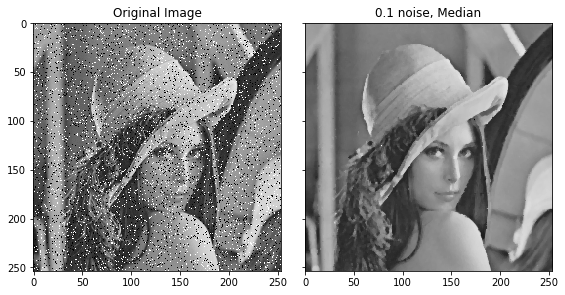

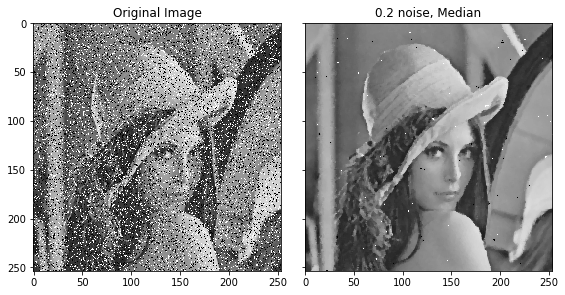

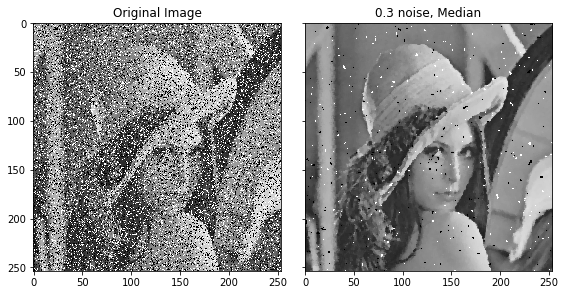

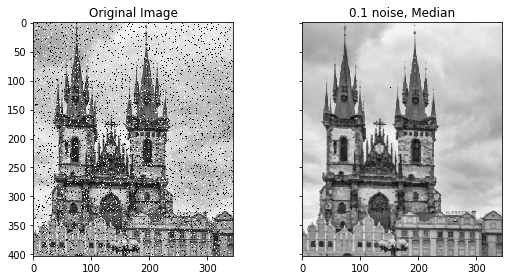

In [190]:
# Let's test this on few different images
apply_median_images(3, 3, 'images/lady.png', 0.1, '0.1 noise, Median')
apply_median_images(3, 3, 'images/lady.png', 0.2, '0.2 noise, Median') # increase the amount of noise
apply_median_images(3, 3, 'images/lady.png', 0.3, '0.3 noise, Median') # increase the amount of noise
apply_median_images(3, 3, 'images/prague.jpg', 0.1, '0.1 noise, Median')
apply_median_images(3, 3, 'images/prague.jpg', 0.2, '0.2 noise, Median') # increase the amount of noise
apply_median_images(5, 5, 'images/prague.jpg', 0.3, '0.3 noise, Increased window, Median filter') # increase the amount of noise, increase the size of the median window


### Exercise 4. Edge Detection (30 pts)

In this exercise, you will need to choose an image processing libary that provides edge detection (see Szeliski chapter 4).  It should provide different types of edge detection and allow for control over smoothing.

4.1 (5 pts) Explain how you chose your library and what options you considered (briefly) and demonstrate the interface on two different types of edge detection algorithms.

4.2 (5 pts) Select a few noise-free images and show how edge detection can work at some scales but not at others.  Explain what is happening in terms of the edge-detection algorithm.

4.3 (5 pts) Add varying amounts of noise to an image and show how edge detection degrades.  Again explain what is happening in terms of the algorithm.

4.4 (5 pts) Now use these same noisy images but use smoothing to improve the edge detection and compare the results to the original noise-free image.

4.5 (5 pts) Select images to illustrate how an edge detection can detect numerous types of boundaries that correspond to distinct types of structure in the real world.

4.6 (5 pts) Now select images to illustrate different ways in which edge detection can fail, in the sense that the boundary is clear visible to us, but isn't detectable by the algorithm.

## Exercise 4

### 4.1
I have decided to look at Scikit-image, OpenCV, and Mahotas. 

- The Scikit-image library is very fast as it is uses NumPy for arrays as image objects by transforming the original pictures and NumPy is built on C. For edge detection, the Canny edge detector algorithm is implemented. There are four different edge operators in Sickit-image: farid, sobel, scharr, prewitt. We can control the smoothing by adjusting the sigma parameter.
- OpenCV is simple to use and fairly readable. OpenCV as initially written in C++ but it comes with a Python wrapper. OpenCV also uses the Canny edge detector algorithm, and has parameters to control hysteresis procedure.
- Mahotas performs advanced image processing such as haralick and local binary patterns. Mahotas does edge detection using Sobel.

I have decided to go with Scikit-image due to its flexibility and speed. 

First we will use the Canny edge detector algorithm and the sobel edge operator. Technically the sobel, farid and other methods use the same algorithm for sliding the kernel window; however, they vary the edge operator. We can still compare it to Canny edge detector.

In [191]:
def sobel_custom(filename):
    """
    Applies the sobel edge operator to an image.
    
    Parameters:
    filename (String): location of the image
    """
    image = imread(filename)
    image = rgb2gray(image) 
    edge_sobel = sobel(image)
    
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(8, 4))

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[1].set_title('Sobel Edge Detection')

    plt.tight_layout()
    plt.show()
    
def canny_custom(filename, sigma, rgb, title):
    """
    Applies the canny edge detector to an image.
    
    Parameters:
    filename (String): location of the image
    sigma (int): amount of smoothing added
    rgb (bool): changes the image to grayscale if it is not already
    title (String): adds a custom label to the figure
    """
    image = io.imread(filename)
    
    if rgb:
        image = rgb2gray(image)
    
    edge_canny = feature.canny(image, sigma)

    # display results
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(8, 4))

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(edge_canny, cmap=plt.cm.gray)
    ax[1].set_title(title)

    plt.tight_layout()
    plt.show()
    
def rgb2gray(rgb):
    """
    Converts an rgb image to grayscale.
    
    Parameters:
    rgb (image array): image to be converted

    Returns:
    image array: grayscale image
    """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [192]:
# let's try this function on different images
sobel_custom('images/lady.png')
canny_custom('images/lady.png', 4, True, "Canny Edge Detection")

### 4.2
Let's use the Canny algorithm because it allows us to adjust the smoothing variable.

The Canny edge detection algorithm works as follows: 
- First, it applies a gradient filter to remove noise and smooth the image
- Next, it computes the change in pixel intensity in the image
- Next, it removes spurious results, in other words, pixels that are not local maxima in the direction of the gradient. This suppresses thick edges.
- Last, in order to determine potential edges, the algorithm uses double treshold to the intensity gradients. Values that are higher, or lower than the treshold are consided non-edges.  If pixels between the tresholds are connected to sure-edges, than they also become edges themselves. This removes pixel noise. 

Lets look at an image of a black and white noise-free pattern that's increasingly zoomed into:

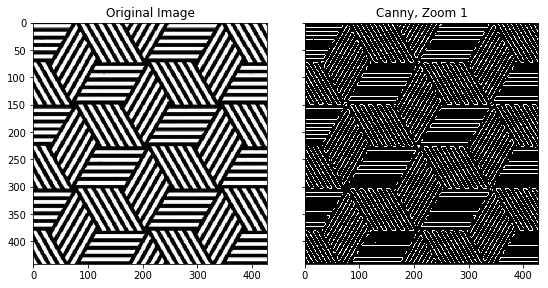

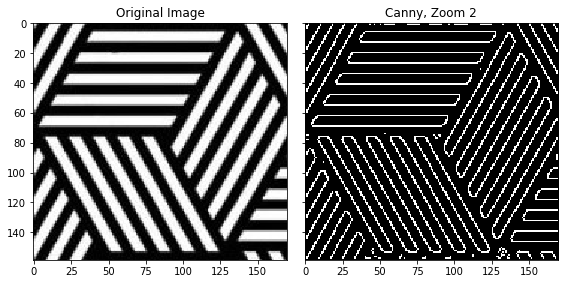

In [193]:
canny_custom('images/pattern1.jpg', 1, True, "Canny, Original") # original image
canny_custom('images/pattern2.jpg', 1, True, "Canny, Zoom 1") # zoom 1
canny_custom('images/pattern3.jpg', 1, True, "Canny, Zoom 2") # zoom 2

We can see that the more we zoom into the image the easier it is for the algorithm to pick up the edges. This is due to the algorithm functionality. Canny cannot pickup images with many small, short edges or thick edges as well as long edges. It also does not function as well with diagonal or circular patterns. That is apparent from the first image that mainly highlights the horizontal pieces of the pattern. In the first zoom, the algorithm is able to highlight the diagonal lines but not as confidently as the horizontal ones. The edge detector works the best in the last image.

### 4.3
Let's pick a simple image and start adding noise to it. I will modify the function above to take a noise amount as an input variable.


In [194]:
def add_noise_canny(file_name, sigma, noise_amount, title):
    """
    Adds noise to an image an then applies the canny algorithm.
    
    Parameters:
    filename (String): location of the image
    sigma (int): amount of smoothing added
    noise_amount (int): amount of salt and pepper noise
    title (String): adds a custom label to the figure
    """
    
    # Load the image
    image = cv2.imread(file_name)

    # Add salt-and-pepper noise to the image.
    noise_img = random_noise(image, mode='s&p',amount=noise_amount)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    
    noise_img = rgb2gray(noise_img)
    edge_canny = feature.canny(noise_img, sigma)

    # display results
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(8, 4))

    ax[0].imshow(noise_img, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(edge_canny, cmap=plt.cm.gray)
    ax[1].set_title(title)

    plt.tight_layout()
    plt.show()

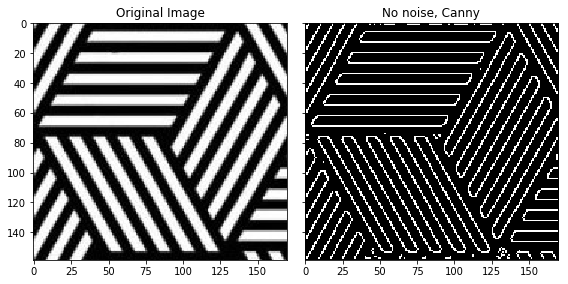

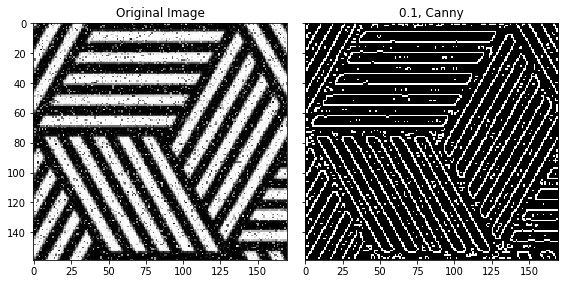

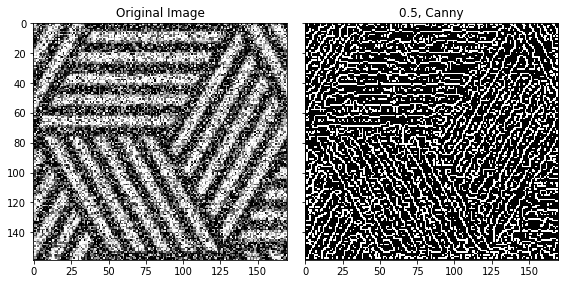

In [195]:
add_noise_canny('images/pattern3.jpg', 1, 0, "No noise, Canny")
add_noise_canny('images/pattern3.jpg', 1, 0.1, "0.1, Canny")
add_noise_canny('images/pattern3.jpg', 1, 0.3, "0.3, Canny")
add_noise_canny('images/pattern3.jpg', 1, 0.5, "0.5, Canny")
    


We can see that the algorithm degrades with increased noise. The algorithm tries to compensate for the noise by at first smoothing the image using gradient filter. However, I have decreased the value of the parameter to demonstrate the decay.

With increased noise near the edges the algorithm assumes that they are local maxima since they appear in the direction of the gradient. When using double threshold to find the intensity gradients, the noise matches the threshold value and is assumed to be an edge.

### 4.4
Let's attempt to improve the edge detection of the images above by changing the sigma constant.


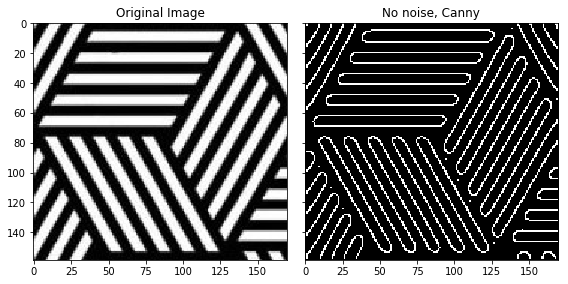

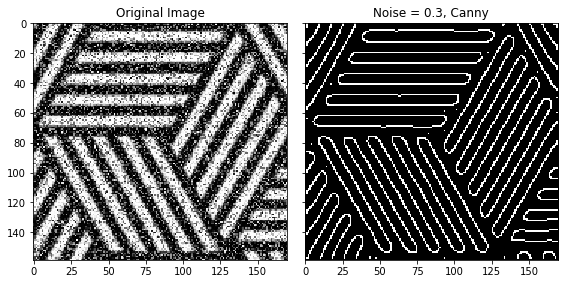

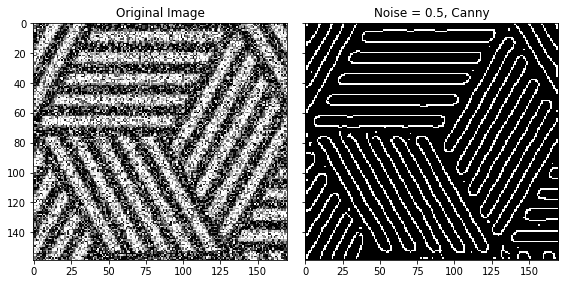

In [196]:
add_noise_canny('images/pattern3.jpg', 3, 0, "No noise, Canny")
add_noise_canny('images/pattern3.jpg', 3, 0.1, "Noise = 0.1, Canny")
add_noise_canny('images/pattern3.jpg', 3, 0.3, "Noise = 0.3, Canny")
add_noise_canny('images/pattern3.jpg', 3, 0.5, "Noise = 0.5, Canny")
    


We can see that even by slighly increasing the smoothing variable from 1 to 3, the images processed image becomes much more clear. That is because the noise is removed in the initial processing stage and does not factor into the final gradient edge detection.


### 4.5
I have selected images that correspond to edges with varying lightness changes, and have objects in the foreground and background. For the image of the woman, we can see that the edge detector highlights the shades on her face as well as the blurred objects in the background. 

In the case of the fruit bowl, we can see the pattern and shading on the bowl as well as the shade of the bowl on the table is highlighted by the edge detector.

For the blurred image of NYC, the edge detector still highlight the two blurred skyscrapers as well as the smaller buildings.

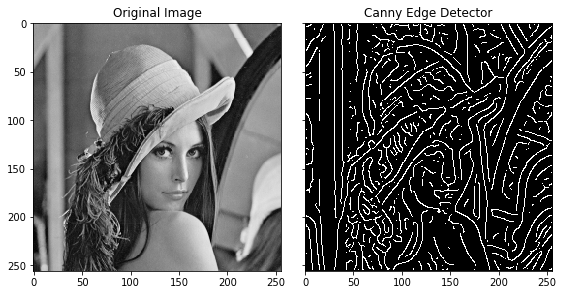

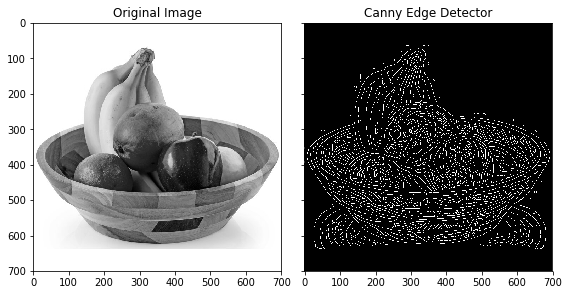

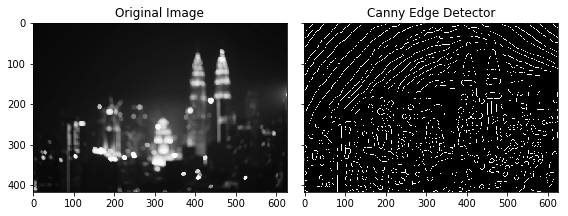

In [197]:
canny_custom('images/lady.png', 2.5, True, "Canny Edge Detector")
canny_custom('images/fruit.jpg', 2.5, True, "Canny Edge Detector")
canny_custom('images/ny.jpg', 4, True, "Canny Edge Detector")

### 4.6
The algorithm does not function with images that have many smaller, shorter edges that are not strictly vertical and horizontal. In the case of the image below, there are too many edges for small resolution, and adjusting the smoothing parameter does not make the results better.


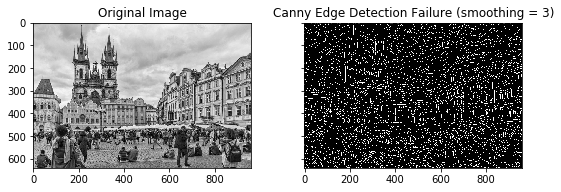

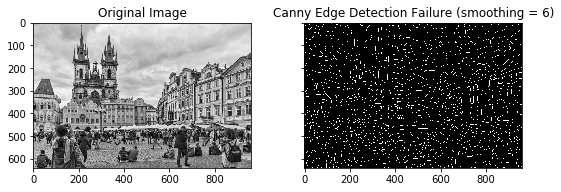

In [198]:
canny_custom('images/prague2.jpg', 3, True, "Canny Edge Detection Failure (smoothing = 3)")
canny_custom('images/prague2.jpg', 6, True, "Canny Edge Detection Failure (smoothing = 6)")

### Exploration (40 pts)

In these problems, you are meant to do creative exploration. This is meant to be open-ended; you should not feel the need to write a book chapter; but neither should you just change the numbers in one of the problems above.  After doing the readings and problems above, you should pick a concept you want to understand better or an simple modeling idea you want to try out.  You can also start to explore ideas for your project. 

Some other ideas:
- reproduce a figure from the readings
- derive or illustrate equations from the readings
- any of the exercises in Szeliski Ch. 3.

The general idea is for you to teach yourself (and potentially a classate) about a concept from the assignments and readings or solidify your understanding of required technical background.

### Exploration 

For the exploration section, I wanted to see if using RGB images would have an effect on the performance of the algorithms mentioned above. I have decided to program new functions that are able to decompose images into three separate arrays and analyze each separately. I will perform this analysis for the linear, non-linear filters and for the edge detection using the Sobel, Prewitt, Roberts, and Scharr algorithms.

#### Linear filters

First, we are going to look at how linear filtering changes with RGB separate.

In [199]:
def apply_2D_filter_RGB(kernel, image_array):
    """
    Iterates through 3 color channels.
    
    Parameters:
    kernel (list of lists): 2D kernel that modifies the image
    image_array (list of lists): input image as a 3D array 

    Returns:
    int: modified image array, convolved with the kernel
    """
    
    image_array = np.asarray(image_array)
    kernel = np.asarray(kernel)

    #make a new image array
    offset = kernel.shape[0] // 2
    new_image_array = np.zeros(shape = (image_array.shape[0] - 2 * offset, image_array.shape[1] - 2 * offset, image_array.shape[2]))
    
    for x in range(image_array.shape[2]):
        
        # Extract the layer and create a new layer to fill in 
        layer = image_array[:, :, x]
        new_layer = np.zeros(shape = (layer.shape[0] - 2 * offset, layer.shape[1] - 2 * offset), dtype='uint8')
        
        for i in range(offset, image_array.shape[0] - offset):
                for j in range(offset, image_array.shape[1] - offset):

                    #Place the kernel anchor on top of a determined pixel, with the rest of the kernel overlaying the corresponding local pixels in the image
                    patch = layer[i - offset : i - offset + kernel.shape[0], j - offset : j - offset + kernel.shape[0]]

                    #Multiply the kernel coefficients by the corresponding image pixel values and sum the result.
                    product = np.multiply(patch, kernel)
                    sum = np.sum(product)

                    #Place the result to the location of the anchor in the input image.
                    new_layer[i - offset][j - offset] = sum
                    
        new_image_array[:, :, x] = new_layer
                
    new_image_array = new_image_array.astype(int)
    return new_image_array


In [200]:
def apply_2d_filter_RGB_image(kernel, image_path, title):
    """
    Iterates through 3 color channels.
    
    Parameters:
    kernel (list of lists): 2D kernel that modifies the image
    image_path (String): file path to the image
    title (String): title of the figure displayed above the image

    Returns:
    int: modified image, convolved with the kernel
    """
    
    # Load an image based on the given path
    image = Image.open(image_path)
    
    image_array = np.array(image)
    
    # Convert the images and plot them
    new_image = apply_2D_filter_RGB(kernel, image_array).astype('uint8')
    
    # display results
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(8, 4))

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(new_image, cmap=plt.cm.gray)
    ax[1].set_title(title)

    plt.tight_layout()
    plt.show()

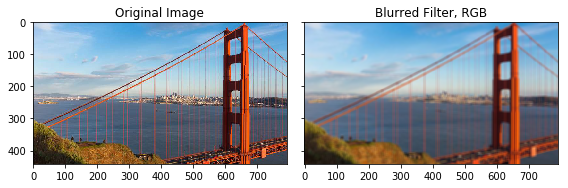

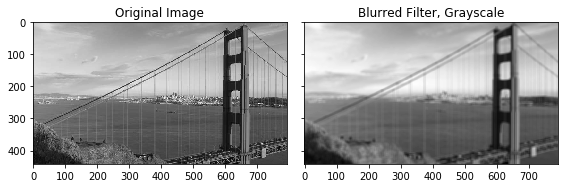

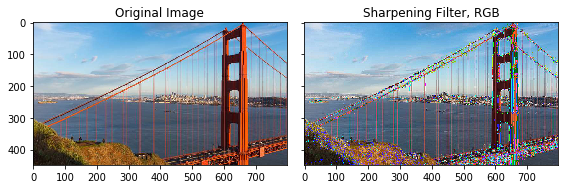

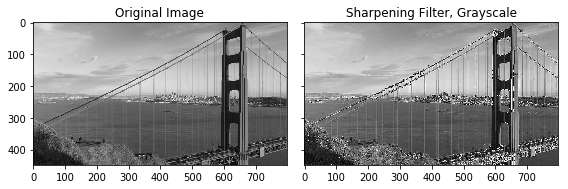

In [201]:
# blurring filter
blurring_kernel = 1/(9*9)*np.ones((9,9)) # blurring kernel
apply_2d_filter_RGB_image(blurring_kernel, 'images/sf.jpg', 'Blurred Filter, RGB')

apply_2d_filter_image(blurring_kernel, 'images/sf.jpg', 'Blurred Filter, Grayscale')

# sharpening filter
sharpening_kernel = [[0, -0.5, 0],
                    [-0.5, 3, -0.5],
                    [0, -0.5, 0]]
apply_2d_filter_RGB_image(sharpening_kernel, 'images/sf.jpg', 'Sharpening Filter, RGB')
apply_2d_filter_image(sharpening_kernel, 'images/sf.jpg', 'Sharpening Filter, Grayscale')

We can see that the blurring filter works well in both scenarios; however, the sharpening filter does not reconstruct well as a final image from its RGB components. We can access each piece individually, and see how each color component is affected by the kernel. I will do that by slightly modifying the function above.

In [202]:
def apply_2d_filter_RGB_image_decompose(kernel, image_path, title):
    """
    Iterates through 3 color channels.
    
    Parameters:
    kernel (list of lists): 2D kernel that modifies the image
    image_path (String): file path to the image
    title (String): title of the figure displayed above the image

    Returns:
    int: modified image, convolved with the kernel
    """
    
    # Load an image based on the given path
    image = Image.open(image_path)
    
    image_array = np.array(image)
    
    # Convert the images and plot them
    new_image = apply_2D_filter_RGB(kernel, image_array).astype('uint8')
    
    # display results
    fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True,
                           figsize=(16, 8))

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(new_image[:,:,0], cmap=plt.cm.gray)
    ax[1].set_title("Sharpened Image, R Component")
    
    ax[2].imshow(new_image[:, :, 1], cmap=plt.cm.gray)
    ax[2].set_title("Sharpened Image, G Component")
    
    ax[3].imshow(new_image[:, :, 2], cmap=plt.cm.gray)
    ax[3].set_title("Sharpened Image, B Component")

    plt.tight_layout()
    plt.show()

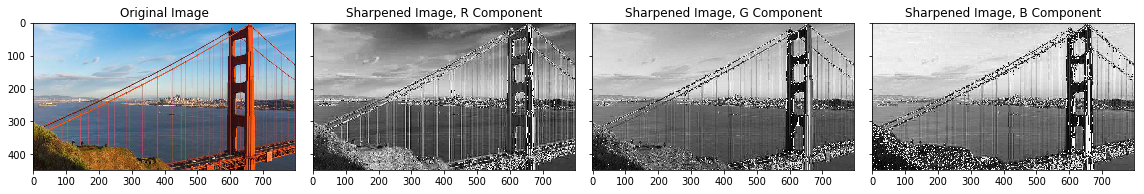

In [203]:
# sharpening filter decomposed into its RGB pieces
sharpening_kernel = [[0, -0.5, 0],
                    [-0.5, 3, -0.5],
                    [0, -0.5, 0]]
apply_2d_filter_RGB_image_decompose(sharpening_kernel, 'images/sf.jpg', 'Sharpened Image')

We can see how different RGB components are sharpened differently and when combined, the color combination does not exactly match its background.

#### Non-linear filters

Next, we are going to look at how non-linear filtering changes with RGB.

In [204]:
def apply_median_filter_RGB(width_w, height_w, image_array):
    """
    Applies a non-linear filter to an RGB image array.
    
    Parameters:
    width_w (int): width of the window we will be iterating over to get the median value
    width_h (int): height of the window we will be iterating over to get the median value 
    
    Returns:
    int: modified 3D image array
    """
    
    image_array = np.asarray(image_array)

    #make a new image array
    offset_w = width_w//2
    offset_h = height_w//2
    
    # TODO fix how we access the shape of the array
    new_image_array = np.zeros(shape = (image_array.shape[0] - 2 * offset_w, image_array.shape[1] - 2 * offset_h, image_array.shape[2]))
    
    
    window = np.empty(shape = (width_w * height_w))

    for x in range(image_array.shape[2]):
        
        # Extract the layer and create a new layer to fill in 
        layer = image_array[:, :, x]
        new_layer = np.zeros(shape = (layer.shape[0] - 2 * offset_w, layer.shape[1] - 2 * offset_h), dtype='uint8')
        
        for i in range(offset_w, image_array.shape[0] - offset_w):
            for j in range(offset_h, image_array.shape[1] - offset_h):
                k = 0
                for fx in range(0, width_w):
                    for fy in range(0, height_w):
                        
                        
                        window[k] = layer[i + fx - offset_w][j + fy - offset_h]
                        k = k + 1
                       
                # sort to get the median
                window = np.sort(window)
                
                #Place the result to the location of the anchor in the input image.
                new_layer[i - offset_w][j - offset_h] = window[(width_w * height_w) // 2]

        new_image_array[:, :, x] = new_layer
    
    new_image_array = new_image_array.astype(int)
    return new_image_array

In [205]:
def apply_median_image_RGB (width_w, height_w, image_path, noise_amount, title):
    """
    Applies a non-linear filter to a 3D image.
    
    Parameters:
    width_w (int): width of the window we will be iterating over to get the median value
    width_h (int): height of the window we will be iterating over to get the median value
    image_array (list of lists): input image as an 3D RGB 
    title (String): title of the image
    """
    
    # Load an image based on the given path
    image = Image.open(image_path)
    
    image_array = np.array(image)
    
    # Add salt-and-pepper noise to the image.
    noise_img = random_noise(image_array, mode='s&p',amount=noise_amount)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    
    # Convert the images and plot them
    new_image = apply_median_filter_RGB(width_w, height_w, noise_img).astype('uint8')

    # display results
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(8, 4))

    ax[0].imshow(noise_img, cmap=plt.cm.gray)
    ax[0].set_title('Original Image')

    ax[1].imshow(new_image, cmap=plt.cm.gray)
    ax[1].set_title(title)

    plt.tight_layout()
    plt.show()

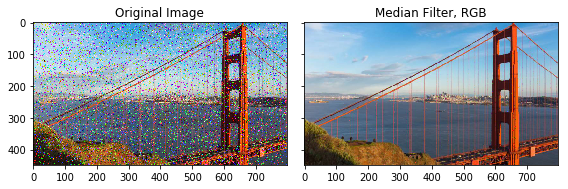

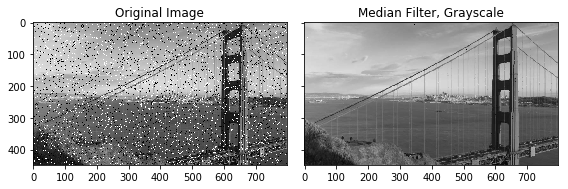

In [206]:
# RGB image
apply_median_image_RGB(3, 3, 'images/sf.jpg', 0.1, "Median Filter, RGB")

# grayscale image
apply_median_images(3, 3, 'images/sf.jpg', 0.1, "Median Filter, Grayscale")

Median filtering works very well for both colored  and greyscale images. Even with increasing the amount of noise the original image can be recovered.

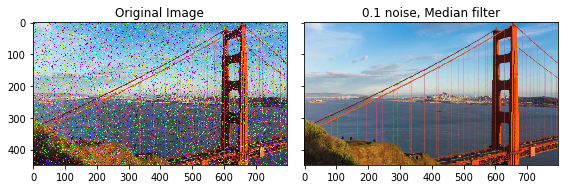

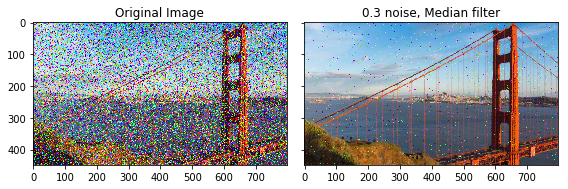

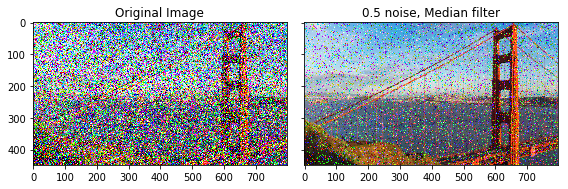

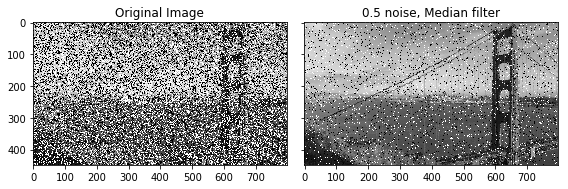

In [207]:
# RGB image
apply_median_image_RGB(3, 3, 'images/sf.jpg', 0.1, '0.1 noise, Median filter')
apply_median_image_RGB(3, 3, 'images/sf.jpg', 0.3, '0.3 noise, Median filter')
apply_median_image_RGB(3, 3, 'images/sf.jpg', 0.5, '0.5 noise, Median filter')
apply_median_images(3, 3, 'images/sf.jpg', 0.5, '0.5 noise, Median filter')

The RGB image actually appears more clear with the 0.5 salt and pepper noise then the grayscale one. Let's show how different components of RGB are recovered.

In [208]:
def apply_median_image_RGB_decompose (width_w, height_w, image_path, noise_amount, title):
    """
    Applies a non-linear filter to a 3D image.
    
    Parameters:
    width_w (int): width of the window we will be iterating over to get the median value
    width_h (int): height of the window we will be iterating over to get the median value
    image_array (list of lists): input image as an 3D RGB 
    title (String): title of the image
    """
    
    # Load an image based on the given path
    image = Image.open(image_path)
    
    image_array = np.array(image)
    
    # Add salt-and-pepper noise to the image.
    noise_img = random_noise(image_array, mode='s&p',amount=noise_amount)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    
    # Convert the images and plot them
    new_image = apply_median_filter_RGB(width_w, height_w, noise_img).astype('uint8')
    
    # display results
    fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True,
                           figsize=(16, 9))

    ax[0].imshow(noise_img, cmap=plt.cm.gray)
    ax[0].set_title('Noisy Image')

    ax[1].imshow(new_image[:,:,0], cmap=plt.cm.gray)
    ax[1].set_title("Median Filter, R Component")
    
    ax[2].imshow(new_image[:, :, 1], cmap=plt.cm.gray)
    ax[2].set_title("Median Filter, G Component")
    
    ax[3].imshow(new_image[:, :, 2], cmap=plt.cm.gray)
    ax[3].set_title("Median Filter, B Component")
    
    ax[4].imshow(new_image, cmap=plt.cm.gray)
    ax[4].set_title("Median Filter, Combined")

    plt.tight_layout()
    plt.show()

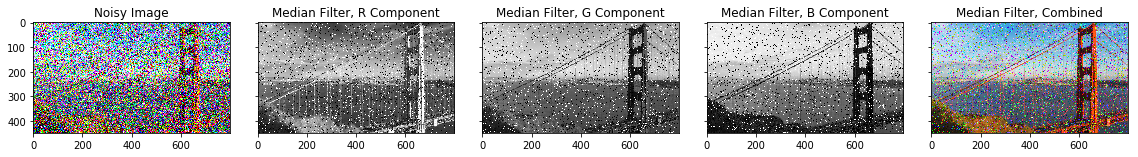

In [209]:
apply_median_image_RGB_decompose (3, 3, 'images/sf.jpg', 0.5, 'title')

Each component removes the one of the three color components of the noise. So when combined together the image appears less noisy then in its greyscale counterpart. Lastly, let's increase the size of the window and see how the filter performs.

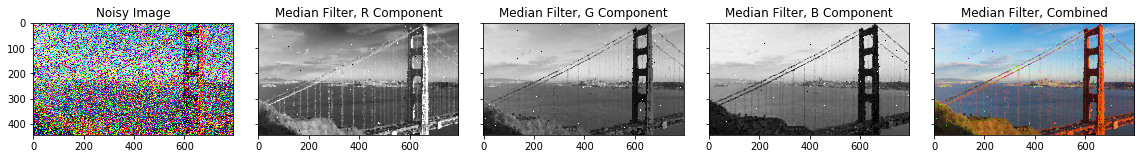

In [210]:
apply_median_image_RGB_decompose (6, 6, 'images/sf.jpg', 0.5, 'title')

#### Edge Detectors

Let's see if edge detection could be improved by analyzing an image as RGB. I am going to look at four different edge operators: roberts, sobel, scharr, and prewitt.

In [211]:
def edge_detection_custom_RGB(filename, edge_operator, title, decompose):
    """
    Applies a non-linear filter to a 3D image.
    
    Parameters:
    width_w (int): width of the window we will be iterating over to get the median value
    width_h (int): height of the window we will be iterating over to get the median value
    image_array (list of lists): input image as an 3D RGB 
    title (String): title of the image
    """
    image = imread(filename)

    new_image_array = np.zeros(shape = (image.shape[0], image.shape[1], image.shape[2]))
    rgb_list = []

    for x in range(image.shape[2]):
        edge_layer = edge_operator(image[:,:,x])
        new_image_array[:, :, x] = edge_layer
        rgb_list.append(edge_layer)
    
    new_image_array = np.array(255*new_image_array, dtype = 'uint8')
    new_image_array = new_image_array.astype(int)
    
    if decompose:
        fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True,
                               figsize=(16, 8))

        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].set_title('Original Image')

        ax[1].imshow(rgb_list[0], cmap=plt.cm.gray)
        ax[1].set_title('R component')

        ax[2].imshow(rgb_list[1], cmap=plt.cm.gray)
        ax[2].set_title('G component')

        ax[3].imshow(rgb_list[2], cmap=plt.cm.gray)
        ax[3].set_title('B component')

        ax[4].imshow(new_image_array, cmap=plt.cm.gray)
        ax[4].set_title(title)
    else:
        fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))

        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].set_title('Original Image')

        ax[1].imshow(new_image_array, cmap=plt.cm.gray)
        ax[1].set_title(title)


    plt.tight_layout()
    plt.show()

Sobel Edge Detection, all channels


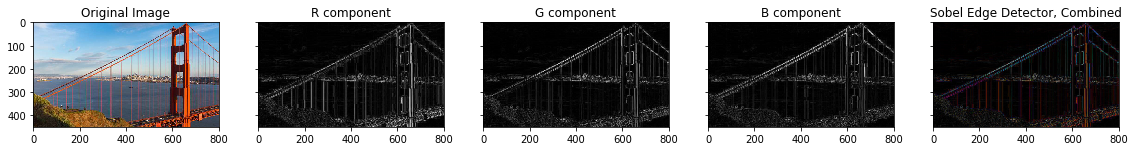

Roberts Edge Detection, all channels


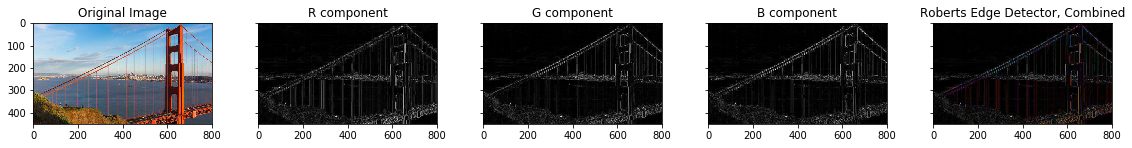

Scharr Edge Detection, all channels


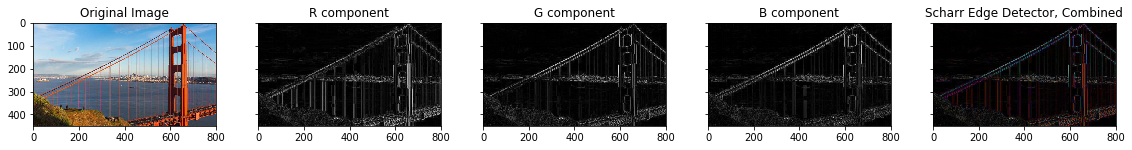

Prewitt Edge Detection, all channels


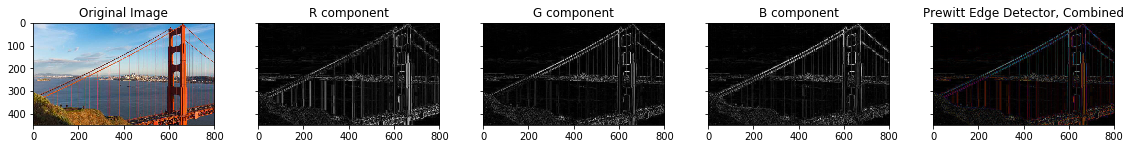

In [212]:
print("Sobel Edge Detection, all channels")
edge_detection_custom_RGB('images/sf.jpg', sobel, 'Sobel Edge Detector, Combined', True)

print("Roberts Edge Detection, all channels")
edge_detection_custom_RGB('images/sf.jpg', roberts, 'Roberts Edge Detector, Combined', True)

print("Scharr Edge Detection, all channels")
edge_detection_custom_RGB('images/sf.jpg', scharr, 'Scharr Edge Detector, Combined', True)

print("Prewitt Edge Detection, all channels")
edge_detection_custom_RGB('images/sf.jpg', prewitt, 'Prewitt Edge Detector, Combined', True)

We can see that the various edge detectors perform in a similar fashion. Interestingly, the combined image has slight coloration that distinguishes which color channel gave rise to the clearest version of that edge.

Let's do a brief comparison to a grayscale image under sobel edge detector for the same image.

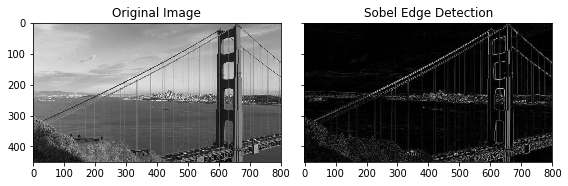

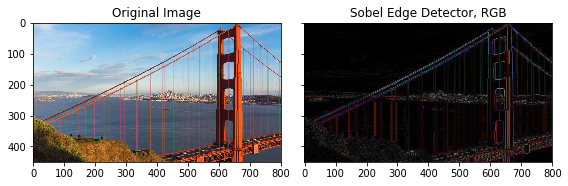

In [213]:
sobel_custom('images/sf.jpg')
edge_detection_custom_RGB('images/sf.jpg', sobel, 'Sobel Edge Detector, RGB', False)

# TODO noise resistane
# TODO hard to analyze before, images
# TODO wrap up

The coloration is clearly visible in the RGB decomposition method. The edge detector also performs better under RGB as can be seen under the highlighted ropes of the Golden Gate bridge. Let's look at some other images, particularly the ones hard to analyze by the Canny algorithm.

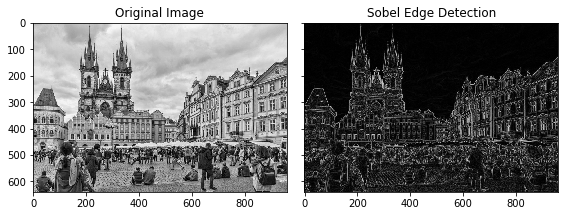

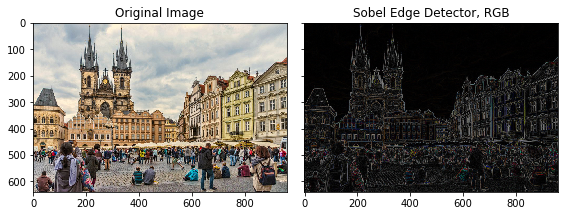

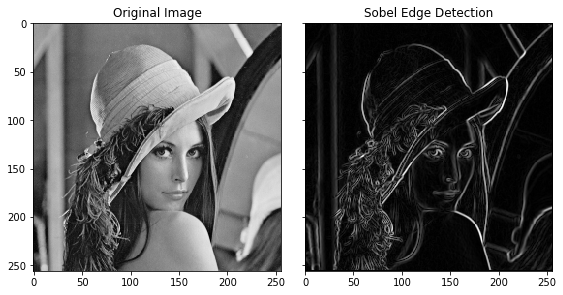

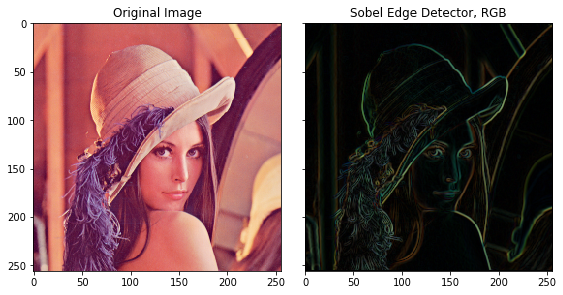

In [214]:
sobel_custom('images/prague2.jpg')
edge_detection_custom_RGB('images/prague2.jpg', sobel, 'Sobel Edge Detector, RGB', False)


sobel_custom('images/lady.png')
edge_detection_custom_RGB('images/lady.png', sobel, 'Sobel Edge Detector, RGB', False)

We can see in the images above that the Sobel edge detector functions well in both scenarios. However, there are certain scenarios were grayscale edge detection fails and we will explore that below.

#### Advantages of doing color edge detection
Noticeable edges between iso-luminant colors (colors with the same luminance) are useful cues but fail to be detected by grayscale edge operators. Let's look at some instances of that below. 

We can see that the final image does not reconstuct because the signed gradients cancel each other; however, that could be fixed by using the oriented energy approach (Morrone and Burr 1988; Perona and Malik 1990). Nonetheless, we extract more information from the image by analyzing its individual components.

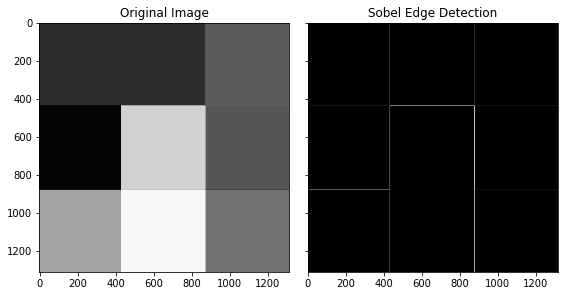

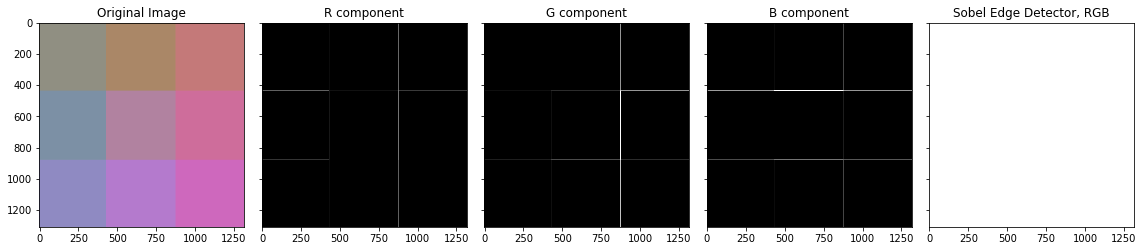

In [215]:
sobel_custom('images/colors.png')
edge_detection_custom_RGB('images/colors.png', sobel, 'Sobel Edge Detector, RGB', True)

Overall, we can see that analyzing the image as an RGB is more advantageous for linear, non-linear filtering and edge detection. The colors give us additional information that improves the precision of our analysis.

#### Exploration Grading Rubric

Exploration problems will be graded according the elements in the table below.  The scores in the column headers indicate the number of points possible for each rubric element (given in the rows).  A score of zero for an element is possible if it is missing entirely.

|   Element  | Substandard (+1) | Basic (+2) | Good (+3) | Excellent (+5) |
| :-- | :----------- | :---- | :--- | :-------- |
| <b> Pedagogical Value </b> | No clear statement of idea or concept being explored or explained; lack of motivating questions. | Simple problem with adequate motivation; still could be a useful addition to an assignment. | Good choice of problem with effective illustrations of concept(s).  Demonstrates a deeper level of understanding. | Problem also illustrates or clarifies common conceptual difficulties or misconceptions. |
| <b> Novelty of Ideas </b> | Copies existing problem or makes only a trivial modification; lack of citation(s) for source of inspiration. | Concepts are similar to those covered in the assignment but with some modifications of an existing exericse. | Ideas have clear pedagogical motivation; creates different type of problem or exercise to explore related or foundational concepts more deeply. | Applies a technique or explores concept not covered in the assignment or not discussed at length in lecture. |
| <b> Clarity of Explanation </b> | Little or confusing explanation; figures lack labels or useful captions; no explanation of motivations. | Explanations are present, but unclear, unfocused, wordy or contain too much technical detail. | Clear and concise explanations of key ideas and motivations. | Also clear and concise, but includes illustrative figures; could be read and understood by students from a variety of backgrounds. |
| <b> Depth of Exploration </b> | Content is obvious or closely imitates assignment problems. | Uses existing problem for different data. | Applies a variation of a technique to solve a problem with an interesting motivation; explores a concept in a series of related problems. | Applies several concepts or techniques; has clear focus of inquiry that is approached from multiple directions.|
